# **5.3 Aggregating transforms**

This section covers transforms that combine multiple rows or multiple columns.

**5.3.1 Combining many rows into summary rows**

Here we address the situation where there are multiple observations or measurements
of a single subject, in this case species of Iris, that we wish to aggregate into a single
observation.

**SCENARIO**

We have been asked to make a report summarizing iris petals by species.

**PROBLEM**

Summarize measurements by category, a

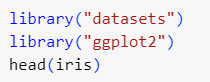

In [1]:
library("datasets")
library("ggplot2")
head(iris)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


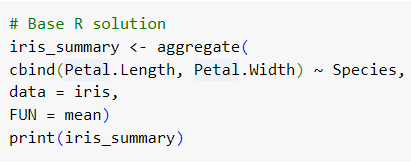

In [4]:
# Base R solution
iris_summary <- aggregate(
cbind(Petal.Length, Petal.Width) ~ Species,
data = iris,
FUN = mean)
print(iris_summary)

     Species Petal.Length Petal.Width
1     setosa        1.462       0.246
2 versicolor        4.260       1.326
3  virginica        5.552       2.026


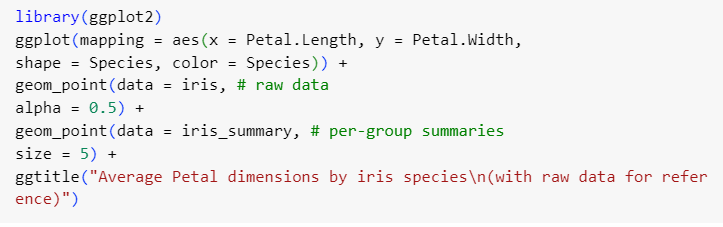

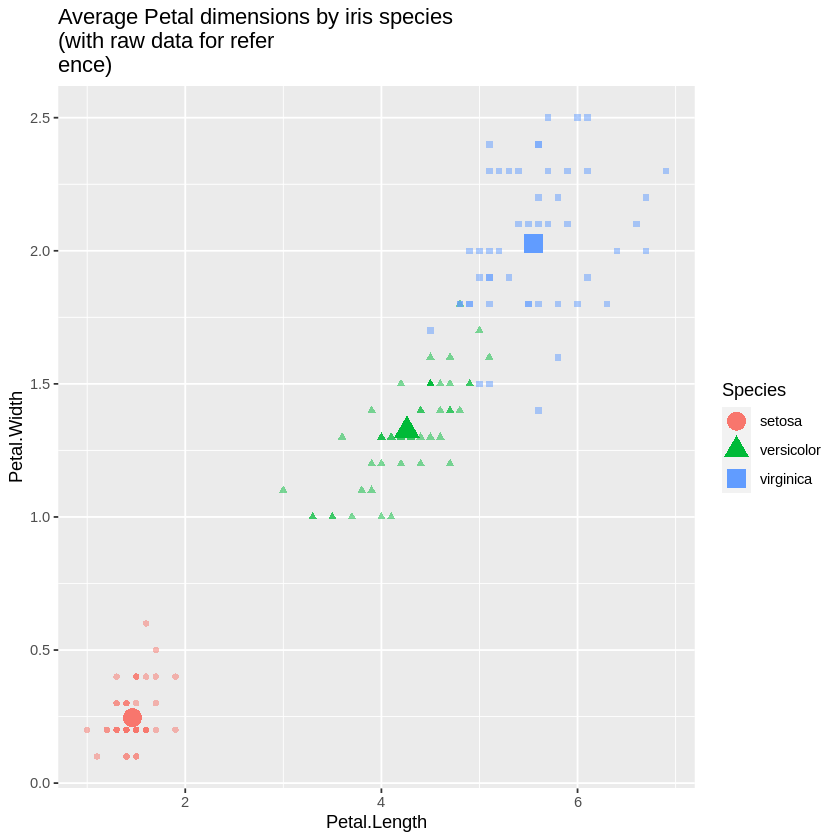

In [5]:
library(ggplot2)
ggplot(mapping = aes(x = Petal.Length, y = Petal.Width,
shape = Species, color = Species)) +
geom_point(data = iris, # raw data
alpha = 0.5) +
geom_point(data = iris_summary, # per-group summaries
size = 5) +
ggtitle("Average Petal dimensions by iris species\n(with raw data for refer
ence)")

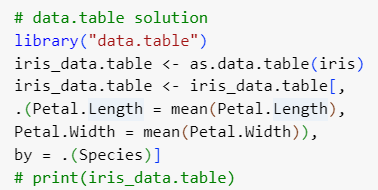

In [7]:
# data.table solution
library("data.table")
iris_data.table <- as.data.table(iris)
iris_data.table <- iris_data.table[,
.(Petal.Length = mean(Petal.Length),
Petal.Width = mean(Petal.Width)),
by = .(Species)]
# print (iris_data.table)
print(iris_data.table)

      Species Petal.Length Petal.Width
1:     setosa        1.462       0.246
2: versicolor        4.260       1.326
3:  virginica        5.552       2.026


**dplyr solution**
* dplyr::group_by
* dplyr::summarize
* A one-argument aggregation function, for example sum or mean

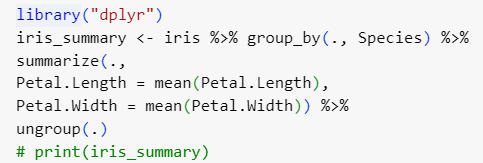

In [10]:
library("dplyr")
iris_summary <- iris %>% group_by(., Species) %>%
summarize(.,
Petal.Length = mean(Petal.Length),
Petal.Width = mean(Petal.Width)) %>%
ungroup(.)
# print(iris_summary)
print(iris_summary)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# A tibble: 3 × 3
  Species    Petal.Length Petal.Width
  <fct>             <dbl>       <dbl>
1 setosa             1.46       0.246
2 versicolor         4.26       1.33 
3 virginica          5.55       2.03 


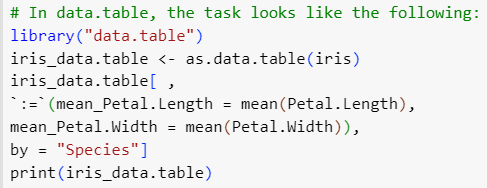

In [18]:
# In data.table, the task looks like the following:
library("data.table")
iris_data.table <- as.data.table(iris)
iris_data.table[,
`:=`(mean_Petal.Length = mean(Petal.Length),
mean_Petal.Width = mean(Petal.Width)),
by = "Species"]
print(iris_data.table)

     Sepal.Length Sepal.Width Petal.Length Petal.Width   Species
  1:          5.1         3.5          1.4         0.2    setosa
  2:          4.9         3.0          1.4         0.2    setosa
  3:          4.7         3.2          1.3         0.2    setosa
  4:          4.6         3.1          1.5         0.2    setosa
  5:          5.0         3.6          1.4         0.2    setosa
 ---                                                            
146:          6.7         3.0          5.2         2.3 virginica
147:          6.3         2.5          5.0         1.9 virginica
148:          6.5         3.0          5.2         2.0 virginica
149:          6.2         3.4          5.4         2.3 virginica
150:          5.9         3.0          5.1         1.8 virginica
     mean_Petal.Length mean_Petal.Width
  1:             1.462            0.246
  2:             1.462            0.246
  3:             1.462            0.246
  4:             1.462            0.246
  5:             1.4

dplyr has similar functionality:

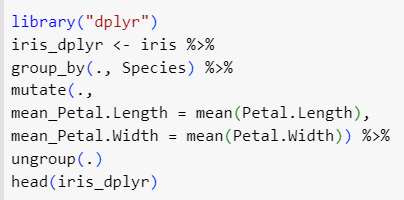

In [19]:
library("dplyr")
iris_dplyr <- iris %>%
group_by(., Species) %>%
mutate (.,
mean_Petal.Length = mean(Petal.Length),
mean_Petal.Width = mean(Petal.Width)) %>%
ungroup(.)
head(iris_dplyr)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,mean_Petal.Length,mean_Petal.Width
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
5.1,3.5,1.4,0.2,setosa,1.462,0.246
4.9,3.0,1.4,0.2,setosa,1.462,0.246
4.7,3.2,1.3,0.2,setosa,1.462,0.246
4.6,3.1,1.5,0.2,setosa,1.462,0.246
5.0,3.6,1.4,0.2,setosa,1.462,0.246
5.4,3.9,1.7,0.4,setosa,1.462,0.246


Again, it is critical to ungroup() when applying per-group transforms. Also, be aware
that dplyr grouped operations (in particular, row selection through filter()) can
be much slower than ungrouped operations, so you want to make your group()/
ungroup() intervals as short as possible. And dplyr grouped operations are usually
much slower than data.table grouped operations in general.


# **5.4 Multitable data transforms**
This section covers operations between multiple tables. This includes the tasks of splitting tables, concatenating tables, and joining tables.

5.4.1 Combining two or more ordered data frames quickly

Here we discuss combining two data frames, with the same number of rows or columns (and same order!).

**SCENARIO**

We have been asked to draw information about products from a sales database and
produce a report. Typically, different facts (in this case, price and units sold) are
stored in different tables, so to produce our report, we will have to combine data from
more than one table

For example, suppose our example data was the following:productTable <-

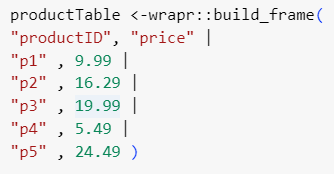

In [22]:
install.packages("wrapr")
library(wrapr)
productTable <- wrapr::build_frame(
"productID", "price" |
"p1" , 9.99 |
"p2" , 16.29 |
"p3" , 19.99 |
"p4" , 5.49 |
"p5" , 24.49 )

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘wrapr’


The following object is masked from ‘package:dplyr’:

    coalesce


The following object is masked from ‘package:data.table’:

    :=




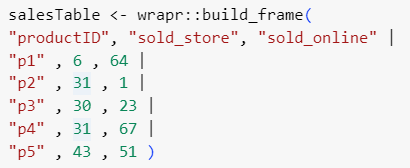

In [24]:
salesTable <- wrapr::build_frame(
"productID", "sold store", "sold_online" |
"p1" , 6, 64 |
"p2" , 31, 1 |
"P3" , 30, 23 |
"pa" , 31, 67 |
"p5" , 43, 51 )


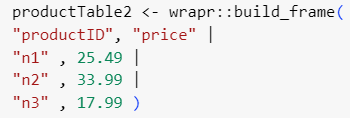

In [26]:
productTable2 <- wrapr::build_frame(
"productID", "price" |
"n1" , 25.49 |
"n2" , 33.99 |
"n3" , 17.99 )

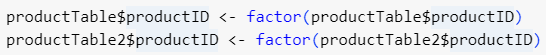

In [29]:
productTable$productID <- factor(productTable$productID)
productTable2$productID <- factor(productTable2$productID)

**PROBLEM 1: APPENDING ROWS**

When two tables have the exact same column structure, we can concatenate them to
get a larger table

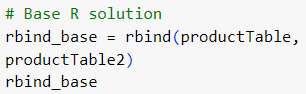

In [30]:
# Base R solution
rbind_base = rbind(productTable,
productTable2)
rbind_base

productID,price
<fct>,<dbl>
p1,9.99
p2,16.29
p3,19.99
p4,5.49
p5,24.49
n1,25.49
n2,33.99
n3,17.99


In [32]:
# Note that rbind creates a new factor variable when merging incompatible factor variables:
str(rbind_base)

'data.frame':	8 obs. of  2 variables:
 $ productID: Factor w/ 8 levels "p1","p2","p3",..: 1 2 3 4 5 6 7 8
 $ price    : num  9.99 16.29 19.99 5.49 24.49 ...


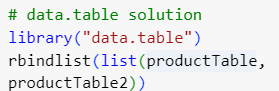

In [31]:
# data.table solution
library("data.table")
rbindlist(list(productTable,
productTable2))

productID,price
<fct>,<dbl>
p1,9.99
p2,16.29
p3,19.99
p4,5.49
p5,24.49
n1,25.49
n2,33.99
n3,17.99


data.table also correctly merges factor types.

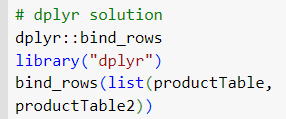

In [33]:
# dplyr solution
dplyr::bind_rows
library("dplyr")
bind_rows(list(productTable,
productTable2))

function (..., .id = NULL) 
{
    dots <- list2(...)
    is_flattenable <- function(x) !is_named(x)
    if (length(dots) == 1 && is_bare_list(dots[[1]])) {
        dots <- dots[[1]]
    }
    dots <- list_flatten(dots, fn = is_flattenable)
    dots <- discard(dots, is.null)
    if (length(dots) == 0) {
        first <- NULL
    }
    else {
        first <- dots[[1L]]
    }
    if (is_named(dots) && !all(map_lgl(dots, dataframe_ish))) {
        return(as_tibble(dots))
    }
    for (i in seq_along(dots)) {
        .x <- dots[[i]]
        if (!dataframe_ish(.x)) {
            abort(glue("Argument {i} must be a data frame or a named atomic vector."))
        }
        if (obj_is_list(.x)) {
            dots[[i]] <- vctrs::data_frame(!!!.x, .name_repair = "minimal")
        }
    }
    if (!is_null(.id)) {
        check_string(.id)
        if (!is_named(dots)) {
            names(dots) <- seq_along(dots)
        }
    }
    else {
        names(dots) <- NULL
    }
    out <- vec_rbind(!!!dots, .names_to = .id, .error_call = current_env())
    if (is.data.frame(first)) {
        out <- dplyr_reconstruct(out, first)
    }
    else {
        out <- as_tibble(out)
    }
    out
}
<bytecode: 0x56499c7e67b8>
<environment: namespace:dplyr>

productID,price
<fct>,<dbl>
p1,9.99
p2,16.29
p3,19.99
p4,5.49
p5,24.49
n1,25.49
n2,33.99
n3,17.99


Notice that bind_rows coerces incompatible factor variables to character.

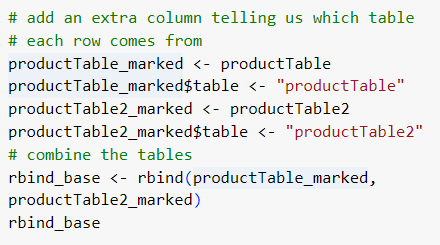

In [36]:
# add an extra column telling us which table
# each row comes from
productTable_marked <- productTable
productTable_marked$table <- "productTable"
productTable2_marked <- productTable2
productTable2_marked$table <- "productTable2"
# combine the tables
rbind_base <- rbind(productTable_marked,
productTable2_marked)
rbind_base

productID,price,table
<fct>,<dbl>,<chr>
p1,9.99,productTable
p2,16.29,productTable
p3,19.99,productTable
p4,5.49,productTable
p5,24.49,productTable
n1,25.49,productTable2
n2,33.99,productTable2
n3,17.99,productTable2


**data.table solution**

data.table combines the split, apply, and recombine steps into a single, very efficient
operation. We will continue our example with the rbind_base object to show the
effect. data.table is willing to call a user function or execute a user expression for
each data group and supplies special variables to work per-group:
* .BY—A named list of the grouping variables and values per group. .BY is a list
of scalars, as by definition grouping variables do not vary per group.
* .SD—A data.table representation of the set of rows for the given group with
the grouping columns removed.
For instance, to compute a max price per group, we can do the following:

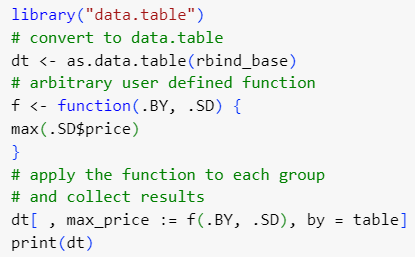

In [53]:
library("data.table")
# convert to data.table
dt <- as.data.table(rbind_base)
# arbitrary user defined function
f <- function(.BY, .SD) {
max(.SD$price)
}
# apply the function to each group
# and collect results
dt[ , max_price := f(.BY, .SD), by = table]
print(dt)

   productID price         table max_price
1:        p1  9.99  productTable     24.49
2:        p2 16.29  productTable     24.49
3:        p3 19.99  productTable     24.49
4:        p4  5.49  productTable     24.49
5:        p5 24.49  productTable     24.49
6:        n1 25.49 productTable2     33.99
7:        n2 33.99 productTable2     33.99
8:        n3 17.99 productTable2     33.99


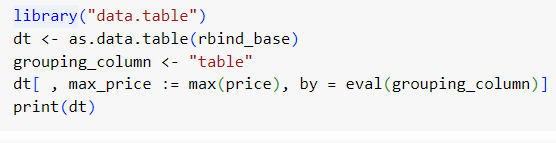

In [57]:
library("data.table")
dt <- as.data.table(rbind_base)
grouping_column <- "table"
dt[ , max_price := max(price), by = eval(grouping_column)]
print(dt)

   productID price         table max_price
1:        p1  9.99  productTable     24.49
2:        p2 16.29  productTable     24.49
3:        p3 19.99  productTable     24.49
4:        p4  5.49  productTable     24.49
5:        p5 24.49  productTable     24.49
6:        n1 25.49 productTable2     33.99
7:        n2 33.99 productTable2     33.99
8:        n3 17.99 productTable2     33.99


**PROBLEM 3: APPENDING COLUMNS**

Append a data frame as columns to another data frame. The data frames must have
the same number of rows and same row order (with respect to what we consider to be
row-keys).

Create a table of product information (price and units sold), from productTable and
salesTable. This assumes that the products are sorted in the same order in both
tables. If they are not, then sort them, or use a join command to merge the tables
together

In [58]:
# Base R solution
# cbind
cbind(productTable, salesTable[, -1])

productID,price,sold store,sold_online
<fct>,<dbl>,<dbl>,<dbl>
p1,9.99,6,64
p2,16.29,31,1
p3,19.99,30,23
p4,5.49,31,67
p5,24.49,43,51


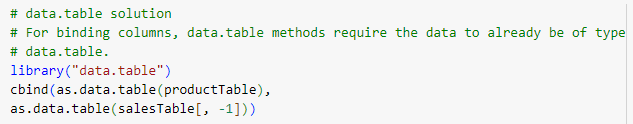

In [60]:
# data. table solution
# For binding columns, data. table methods require the data to already be of type
# data.table.
library("data.table")
cbind(as.data.table(productTable),
as.data.table(salesTable[, -1]))

productID,price,sold store,sold_online
<fct>,<dbl>,<dbl>,<dbl>
p1,9.99,6,64
p2,16.29,31,1
p3,19.99,30,23
p4,5.49,31,67
p5,24.49,43,51


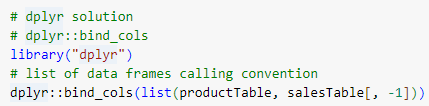

In [61]:
# dplyr solution
# dplyr::bind_cols
library("dplyr")
# list of data frames calling convention
dplyr::bind_cols(list(productTable, salesTable[, -1]))

productID,price,sold store,sold_online
<fct>,<dbl>,<dbl>,<dbl>
p1,9.99,6,64
p2,16.29,31,1
p3,19.99,30,23
p4,5.49,31,67
p5,24.49,43,51


**5.4.2 Principal methods to combine data from multiple tables**

Join is the relational name for the process of combining two tables to create a third.
The join results in a table that possibly has a new row for every pair of rows from the
original two tables (plus possibly rows from each table that did not have matches from
the other table). Rows are matched on key-values, matching from one table to
another. The simplest case is when each table has a set of columns that uniquely determine each row (a unique key), and this is the case we will discuss here.

**SCENARIO**

Our example data is information about products in a sales database. Various facts (in
this case, price and units sold) are stored in different tables. Missing values are
allowed. We are tasked with combining these tables to produce a report.

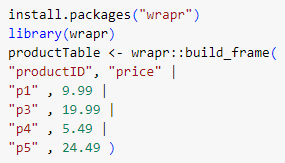

In [62]:
install.packages("wrapr")
library(wrapr)
productTable <- wrapr::build_frame (
"productID", "price" |
"p1" , 9.99 |
"p3" , 19.99 |
"p4" , 5.49 |
"p5", 24.49 )

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



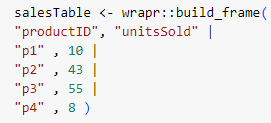

In [64]:
salesTable <- wrapr::build_frame (
"productID", "unitsSold" |
"p1" , 10 |
"p2" , 43 |
"p3" , 55 |
"p4" , 8 )

**LEFT JOIN**

The most important join for the data scientist is likely the left join. This join keeps
every row from the left table and adds columns coming from matching rows in the
right table. When there are no matching rows, NA values are substituted in. Usually,
you design the right table (the second argument to your join command) to have
unique keys; otherwise, the number of rows may grow (there is no need for the left
table to have unique keys).

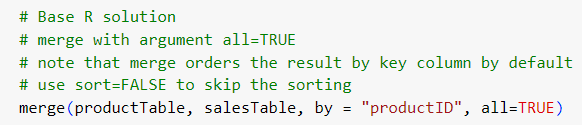

In [65]:
# Base R solution
# merge with argument all=TRUE
# note that merge orders the result by key column by default
# use sort=FALSE to skip the sorting
merge(productTable, salesTable, by = "productID", all=TRUE)

productID,price,unitsSold
<chr>,<dbl>,<dbl>
p1,9.99,10
p2,NA,43
p3,19.99,55
p4,5.49,8
p5,24.49,NA


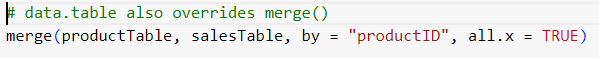

In [66]:
# data.table also overrides merge)
merge(productTable, salesTable, by = "productID", all.x = TRUE)

productID,price,unitsSold
<chr>,<dbl>,<dbl>
p1,9.99,10
p3,19.99,55
p4,5.49,8
p5,24.49,NA


**Base R indexing solution**

The data.table index notation is another very good Base R way
to use one table to add a single column to another: vectorized lookup through the
match() and [] methods

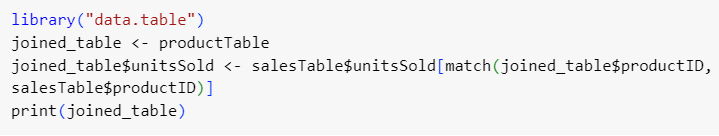

In [70]:
library("data.table")
joined_table <- productTable
joined_table$unitsSold <- salesTable$unitsSold[match(joined_table$productID,
salesTable$productID)]
print(joined_table)

  productID price unitsSold
1        p1  9.99        10
2        p3 19.99        55
3        p4  5.49         8
4        p5 24.49        NA


match() found the matching indices, and [] used the indices to retrieve the data.
Please see help(match) for more details.

In [71]:
# dplyr solution
library("dplyr")
left_join(productTable, salesTable, by = "productID")

productID,price,unitsSold
<chr>,<dbl>,<dbl>
p1,9.99,10
p3,19.99,55
p4,5.49,8
p5,24.49,NA


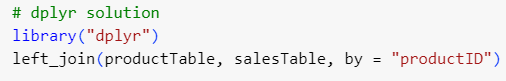

In [72]:
# dplyr solution
library("dplyr")
left_join(productTable, salesTable, by = "productID")

productID,price,unitsSold
<chr>,<dbl>,<dbl>
p1,9.99,10
p3,19.99,55
p4,5.49,8
p5,24.49,NA


**Right join**

There is also a join called right join that is just the left join with the arguments reversed.
As the right join is so similar to the left, we will forgo any right join examples.

**INNER JOIN**

In an inner join, you merge two tables into a single table, keeping only the rows where
the key exists in both tables. This produces an intersection of the two tables,

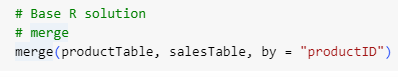

In [74]:
# Base R solution
# merge
merge(productTable, salesTable, by = "productID")

productID,price,unitsSold
<chr>,<dbl>,<dbl>
p1,9.99,10
p3,19.99,55
p4,5.49,8


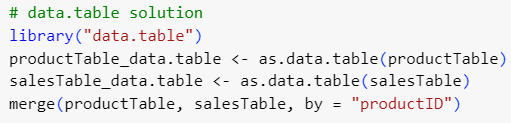

In [76]:
# data. table solution
library("data.table")
productTable_data.table <- as.data.table(productTable)
salesTable_data.table <- as.data.table(salesTable)
merge(productTable, salesTable, by="productID")

productID,price,unitsSold
<chr>,<dbl>,<dbl>
p1,9.99,10
p3,19.99,55
p4,5.49,8


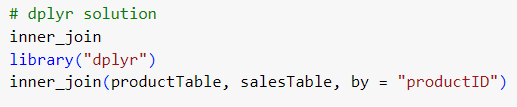

In [77]:
# dplyr solution
inner_join
library("dplyr")
inner_join(productTable, salesTable, by = "productID")

function (x, y, by = NULL, copy = FALSE, suffix = c(".x", ".y"), 
    ..., keep = NULL) 
{
    UseMethod("inner_join")
}
<bytecode: 0x56499c677228>
<environment: namespace:dplyr>

productID,price,unitsSold
<chr>,<dbl>,<dbl>
p1,9.99,10
p3,19.99,55
p4,5.49,8


**FULL JOIN**

In a full join, you merge two tables into a single table, keeping rows for all key values.
Notice that the two tables have equal importance here.

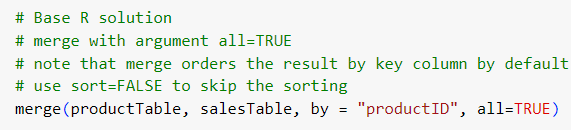

In [78]:
# Base R solution
# merge with argument all=TRUE
# note that merge orders the result by key column by default
# use sort=FALSE to skip the sorting
merge(productTable, salesTable, by = "productID", all=TRUE)

productID,price,unitsSold
<chr>,<dbl>,<dbl>
p1,9.99,10
p2,NA,43
p3,19.99,55
p4,5.49,8
p5,24.49,NA


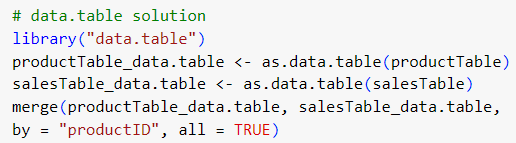

In [80]:
# data.table solution
library("data.table")
productTable_data.table <- as.data.table(productTable)
salesTable_data.table <- as.data.table(salesTable)
merge(productTable_data.table, salesTable_data.table,
by = "productID", all = TRUE)

productID,price,unitsSold
<chr>,<dbl>,<dbl>
p1,9.99,10
p2,NA,43
p3,19.99,55
p4,5.49,8
p5,24.49,NA


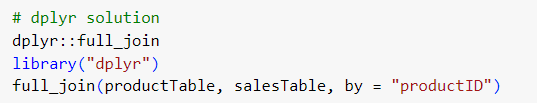

In [82]:
# dplyr solution
dplyr::full_join
library("dplyr")
full_join(productTable, salesTable, by = "productID")

function (x, y, by = NULL, copy = FALSE, suffix = c(".x", ".y"), 
    ..., keep = NULL) 
{
    UseMethod("full_join")
}
<bytecode: 0x56499c6165a0>
<environment: namespace:dplyr>

productID,price,unitsSold
<chr>,<dbl>,<dbl>
p1,9.99,10
p3,19.99,55
p4,5.49,8
p5,24.49,NA
p2,NA,43


**A HARDER JOIN PROBLEM**

The examples we have given up to now do not use row order. Some problems can be
solved much more efficiently with methods that do use row order, such as
data.table's powerful rolling join operation

**Scenario**

You are given historic stock trade and quote (bid/ask) data. You are asked to perform
the following analyses on the stock data: find what the bid and ask price were current
when each trade was performed. This involves using row order to indicate time, and
sharing information between rows.

**Example data**

In stock markets, the bid is the highest price somebody has declared they are willing to
pay for a stock, and the ask is the lowest price that somebody has declared they are
willing to sell a stock for. Bid and ask data are called quotes, and they usually are in an
irregular time series (as new quotes can be formed at arbitrary times, not just at regular intervals), such as the following example:

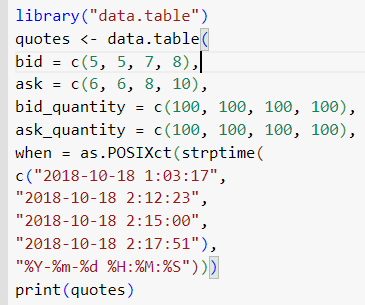

In [89]:
library("data.table")
quotes <- data.table(
bid = c(5, 5, 7, 8),
ask = c(6, 6, 8, 10),
bid_quantity = c(100, 100, 100, 100),
ask_quantity = c(100, 100, 100, 100),
when = as.POSIXct(strptime(
c("2018-10-18 1:03:17",
"2018-10-18 2:12:23",
"2018-10-18 2:15:00",
"2018-10-18 2:17:51"),
"%Y-%m-%d %H:%M:%S")))
print(quotes)

   bid ask bid_quantity ask_quantity                when
1:   5   6          100          100 2018-10-18 01:03:17
2:   5   6          100          100 2018-10-18 02:12:23
3:   7   8          100          100 2018-10-18 02:15:00
4:   8  10          100          100 2018-10-18 02:17:51


Another irregular time series is trades. These are after-the-fact reports about
exchanges of quantities of stock at a given price at a given time.

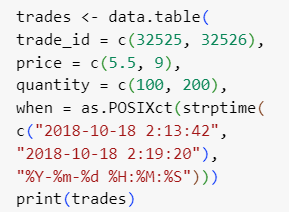

In [93]:
trades <- data.table(
trade_id = c(32525, 32526),
price = c(5.5, 9),
quantity = c(100, 200),
when = as.POSIXct(strptime(
c("2018-10-18 2:13:42",
"2018-10-18 2:19:20"),
"%Y-%m-%d %H:%M:%S")))
print(trades)

   trade_id price quantity                when
1:    32525   5.5      100 2018-10-18 02:13:42
2:    32526   9.0      200 2018-10-18 02:19:20


**Rolling joins**

The data.table rolling join is perfect for finding what was the most recent quote
information for each trade. A rolling join is a type of join on an ordered column that
gives us the most recent data available at the lookup time.

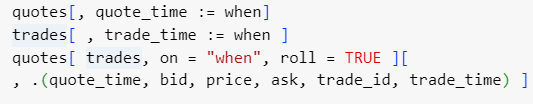

In [94]:
quotes[, quote_time := when]
trades[, trade_time := when]
quotes[ trades, on = "when", roll = TRUE ][
,.(quote_time, bid, price, ask, trade_id, trade_time) ]

quote_time,bid,price,ask,trade_id,trade_time
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>
2018-10-18 02:12:23,5,5.5,6,32525,2018-10-18 02:13:42
2018-10-18 02:17:51,8,9.0,10,32526,2018-10-18 02:19:20


We read the preceding as “for each trade, look up the appropriate quote.” In the join,
the when field comes from the trades, which is why we added a quote_time field so we
could also see when the quote was established. The data.table rolling join is very
fast, and also not easy to efficiently simulate in base R, SQL, or dplyr.
Rolling joins are unique to data.table. In R there are a number of tasks, such as
matching most recent records, that are easily expressed as moving indexes across
rows. However, moving indexes across rows tends to be inefficient in R, as it can’t be
vectorized like column operations can. A rolling join is a direct way of solving such
problems, and has an efficient implementation.